# Pseudotime

**Created**: 14 October 2021

## Environment

In [1]:
if (!requireNamespace("viridis")) {
    install.packages("viridis")
}

if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("Rcpp")) {
    install.packages("Rcpp")
}

if (!requireNamespace("lubridate")) {
    install.packages("lubridate")
}

Loading required namespace: viridis

Loading required namespace: patchwork

Loading required namespace: Rcpp

Loading required namespace: lubridate



In [2]:
library(tidyverse)
library(viridis)
library(RColorBrewer)
library(cowplot)
library(Rcpp)
library(lubridate)
library(Matrix)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite


Attaching package: ‘lubridate’


The following object is masked from ‘package:cowplot’:

    stamp


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    exp

## Load Data

In [3]:
gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt")

ga.prefix.filter <- grepl("GA", rownames(gene.exp))
rownames(gene.exp)[ga.prefix.filter] <- gsub("^GA", "", rownames(gene.exp)[ga.prefix.filter])

head(gene.exp)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000230521,0.6644339,0.58271604,0.4046756,0.20905157,0.2211571,0.4288519,0.5133516,0.57768877,0.6990766,0.3812037,⋯,0.3823184,0.5423684,0.86762630,0.73833461,0.6461583,0.1227063,0.9621386,0.65838459,1.03561474,0.4457301
ENSG00000225864,0.9817872,0.43879936,0.6022344,0.92340489,0.2211571,1.1450686,0.1921362,0.57768877,0.1974851,1.2290495,⋯,0.6842527,0.8539227,0.91886777,0.12581620,0.5511865,0.4384007,0.5465139,0.40803066,0.46899151,0.3544115
ENSG00000227766,1.2117156,0.30682669,0.6625010,0.79963286,0.6445686,0.3130290,0.1183231,0.16750450,0.1505900,1.0533199,⋯,0.4901384,0.4340781,0.37504164,0.04316943,0.6151905,0.3406488,0.3147798,0.43511377,0.17382742,0.1157514
ENSG00000237669,0.6420763,0.69256830,0.9792012,0.69929584,0.3765156,1.0756817,0.8912050,0.60129641,0.8534668,1.0533199,⋯,1.0790156,0.6102946,1.03953331,0.97965846,0.7061683,0.7489857,0.7919934,0.85168813,0.69120049,1.0798771
ENSG00000271581,2.4744895,1.33153140,1.8310464,2.47531701,1.8812042,2.0531366,0.5972544,1.00686213,1.2811361,2.4244938,⋯,2.4728831,1.5338898,1.59080138,0.62923925,1.2804253,1.4727511,1.2187650,1.46471386,1.44139443,1.1896250
ENSG00000285647,0.0000000,0.03379072,0.0000000,0.05517067,0.6748270,0.0000000,0.0000000,0.03509293,0.6990766,1.6556266,⋯,3.4117627,2.4012963,0.04682116,0.00000000,0.0000000,0.4695662,0.3762952,0.07078527,0.07206309,0.4159282


In [4]:
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)

head(eigengenes)

,ME_1,ME_2,ME_3,ME_4,ME_5,ME_6,ME_7,ME_8,ME_9,ME_10,⋯,ME_57,ME_58,ME_59,ME_60,ME_61,ME_62,ME_63,ME_64,ME_65,ME_66
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UK02270173_3,-0.007334113,-0.012539535,0.019766245,0.002754747,0.017331897,-0.03308963,0.037551543,0.035526167,0.007061637,-0.045462098,⋯,-0.03736851,-0.015491299,-0.0003944539,0.011723160,0.02044694,0.036389792,-0.0199594898,-0.0137973687,-0.0226533146,-0.0224921394
UK15130120_3,-0.039218201,-0.028118430,-0.030119369,0.044385750,-0.035924531,-0.01776018,0.048988451,0.032309702,-0.025540316,-0.003352967,⋯,0.03449182,0.009217925,-0.0089077866,0.051934721,0.02981843,-0.012103471,0.0152503786,-0.0008924039,0.0005244192,0.0670088144
UK58000006_3,0.016278695,0.002300409,0.038062533,-0.019970003,0.035664412,-0.02460794,-0.013427286,0.025928161,0.019651683,-0.049510956,⋯,0.03616406,0.004048221,0.0298820001,-0.029996760,0.01875794,-0.009576244,-0.0324318003,0.0003237006,-0.0110317401,-0.0327675701
UK47010004_3,0.012015980,0.022969179,-0.004106886,-0.018628648,0.023430789,0.01904802,0.002796251,-0.011522015,-0.009007830,-0.001991980,⋯,0.02905445,-0.020687733,-0.0147508943,0.001036775,-0.01651732,0.030270486,-0.0053783817,0.0314069529,-0.0060826198,-0.0201014546
UK42020088_5,0.014862024,0.025478183,-0.004896746,-0.002020827,0.001845234,0.02344584,-0.004351176,-0.008517141,0.008746174,0.024165915,⋯,0.03286665,0.001720939,-0.0042298661,-0.010538437,-0.02148751,0.064750526,-0.0006839132,-0.0057871254,0.0119033593,0.0007013236
UK47490007_3,-0.018282178,0.014805866,-0.041274648,0.015737059,-0.004421347,0.03830728,0.003762546,-0.023246260,-0.045245113,0.030086125,⋯,0.02577557,-0.016313161,-0.0323697955,0.016932273,0.02380263,0.035666094,0.0028921852,0.0335825353,0.0320275167,-0.0150428658


In [7]:
sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt")
ga.prefix.filter <- grepl("GA", sample.info$supplier_name)
sample.info$supplier_name[ga.prefix.filter] <- gsub("^GA", "", sample.info$supplier_name[ga.prefix.filter])
ga.prefix.filter <- grepl("GA", sample.info$GAinSID)
sample.info$GAinSID[ga.prefix.filter] <- gsub("^GA", "", sample.info$GAinSID[ga.prefix.filter])
sample.info <- sample.info %>% 
  dplyr::filter(supplier_name %in% rownames(eigengenes))

outcome <- read.table("/nfs/team282/data/gains_team282/ClinicalData/clinical_data_tsv/OUT_12jun2019.tsv", sep="\t", header=T, quote="")

outcome <- outcome %>%
  dplyr::mutate(GAinSID=stringr::str_to_upper(SubjectBarCode))
ga.prefix.filter <- grepl("GA", outcome$GAinSID)
outcome$GAinSID[ga.prefix.filter] <- gsub("^GA", "", outcome$GAinSID[ga.prefix.filter])
outcome <- outcome %>%
  dplyr::mutate(Date.Hospitalized=lubridate::mdy(DhospICU), Date.Death=lubridate::mdy(M6ddeath)) %>%
  dplyr::mutate(Endpoint=as.duration(Date.Hospitalized %--% Date.Death) / lubridate::ddays(1)) %>%
  dplyr::mutate(Endpoint=replace(Endpoint, Endpoint > 28, NA)) %>%
  dplyr::mutate(Status=ifelse(is.na(Endpoint), 0, 1)) %>%
  dplyr::mutate(Endpoint=replace(Endpoint, is.na(Endpoint), 28))
rownames(outcome) <- outcome$GAinSID

sample.info <- merge(sample.info, outcome, by="GAinSID", all.x=TRUE)
rownames(sample.info) <- sample.info$supplier_name
sample.info <- sample.info[rownames(eigengenes),]

head(sample.info)

,GAinSID,manual_qc,id_study_lims,name,description,sanger_sample_id,supplier_name,last_updated,id_library_lims,id_pool_lims,⋯,unrelatc3,unreldesc3,AtLeastOneCause,EDTAsent,DhospICU,Birthdate,Date.Hospitalized,Date.Death,Endpoint,Status
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<date>,<date>,<dbl>,<dbl>
UK02270173_3,UK02270173,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032857,UK02270173_3,2019-09-30 21:01:38,DN548016D,NT1557159B,⋯,0,,0,1,1/17/11,6/4/43,2011-01-17,NA,28,0
UK15130120_3,UK15130120,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032858,UK15130120_3,2019-09-30 21:01:38,DN548016D,NT1557159B,⋯,0,,0,1,1/28/11,5/20/61,2011-01-28,NA,28,0
UK58000006_3,UK58000006,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032859,UK58000006_3,2019-09-30 21:01:38,DN548016D,NT1557159B,⋯,0,,0,1,1/28/11,11/3/54,2011-01-28,NA,28,0
UK47010004_3,UK47010004,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032860,UK47010004_3,2019-09-30 21:01:38,DN548016D,NT1557159B,⋯,0,,1,1,8/16/10,5/2/48,2010-08-16,2011-02-06,28,0
UK42020088_5,UK42020088,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032861,UK42020088_5,2019-09-30 21:01:38,DN548016D,NT1557159B,⋯,0,,0,1,12/6/10,8/4/43,2010-12-06,NA,28,0
UK47490007_3,UK47490007,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032862,UK47490007_3,2019-09-30 21:01:38,DN548016D,NT1557159B,⋯,0,,1,1,11/15/10,8/31/36,2010-11-15,2010-12-10,25,1


In [9]:
srs.info <- read.table("/nfs/team282/data/gains_team282/full-gains-SRS-predictions_mNN-RF.tsv", header=T)
ga.prefix.filter <- grepl("GA", srs.info$Sample_id)
srs.info$Sample_id[ga.prefix.filter] <- gsub("^GA", "", srs.info$Sample_id[ga.prefix.filter])
srs.info <- srs.info %>%
  dplyr::filter(Assay=="RNA-seq")
row.names(srs.info) <- srs.info$Sample_id
srs.info <- srs.info[rownames(eigengenes),]

head(srs.info)

,Sample_id,Assay,SRS,SRSq
,<chr>,<chr>,<chr>,<dbl>
UK02270173_3,UK02270173_3,RNA-seq,SRS2,0.5092
UK15130120_3,UK15130120_3,RNA-seq,SRS2,0.2880
UK58000006_3,UK58000006_3,RNA-seq,SRS2,0.6755
UK47010004_3,UK47010004_3,RNA-seq,SRS1,0.8264
UK42020088_5,UK42020088_5,RNA-seq,SRS1,0.8238
UK47490007_3,UK47490007_3,RNA-seq,SRS2,0.6877


In [10]:
cell.prop <- read.table("04_Expression/data/gene_expression/Cell_props_864.txt", header=TRUE)
ga.prefix.filter <- grepl("GA", cell.prop$Sample)
cell.prop$Sample[ga.prefix.filter] <- gsub("^GA", "", cell.prop$Sample[ga.prefix.filter])
rownames(cell.prop) <- cell.prop$Sample
cell.prop <- cell.prop[rownames(eigengenes),]

head(cell.prop)

,Sample,GAinSID,Day,Neutrophils,Lymphocytes,Monocytes
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
UK02270173_3,UK02270173_3,UK02270173,3,0.8000000,0.11000000,0.09000000
UK15130120_3,UK15130120_3,UK15130120,3,NA,NA,NA
UK58000006_3,UK58000006_3,UK58000006,3,0.8875740,0.06508876,0.04733728
UK47010004_3,UK47010004_3,UK47010004,3,0.8813559,0.06779661,0.05084746
UK42020088_5,UK42020088_5,UK42020088,5,0.8857143,0.07857143,0.03571429
UK47490007_3,UK47490007_3,UK47490007,3,0.9183673,0.05102041,0.03061224


In [11]:
ddr.tree.eigen.time.point <- readRDS("~/gains_team282/nikhil/expression/gene_expression/ddr.tree.eigengenes.time.point.RDS")

ddr.tree.eigen.time.point.branches <- readRDS("~/gains_team282/nikhil/expression/gene_expression/ddr.tree.eigen.time.point.branches.RDS")

eigen.time.point.projected <- readRDS("~/gains_team282/nikhil/expression/gene_expression/ddr.tree.eigen.time.point.projected.RDS")

pseudotime <- readRDS("~/gains_team282/nikhil/expression/gene_expression/eigen.time.point.pseudotime.RDS")

## Plot Trees

I wrote a custom function to plot the generated tree embeddings using `ggplot2`.

In [12]:
plot.tree <- function(ddr.tree, color.factor=c(), factor.name="Factor") {
  
  Z = t(ddr.tree$Z) %>%
    as.data.frame()
  
  Y = t(ddr.tree$Y) %>%
    as.data.frame()
  
  tree = as.data.frame(summary(ddr.tree$stree)) %>%
    dplyr::filter(i < j) %>%
    dplyr::mutate(StartComp1=Y$Comp1[i], StartComp2=Y$Comp2[i], EndComp1=Y$Comp1[j], EndComp2=Y$Comp2[j])
  
  Y$Degree = table(c(tree$i, tree$j))[1:nrow(Y)]
    
  Y.branch.points = Y %>%
    dplyr::filter(Degree != 2)
  
  if (length(color.factor) == 0) {
    
    p = ggplot() +
      geom_point(data=Z, aes(x=Comp1, y=Comp2), alpha=0.25, color="royalblue4") + 
      geom_segment(data=tree, aes(x=StartComp1, y=StartComp2, xend=EndComp1, yend=EndComp2), size=I(2)) +
      geom_point(data=Y.branch.points, aes(x=Comp1, y=Comp2), size=I(4), color="firebrick3")
  } else if (class(color.factor) == "factor") {
    
    Z = Z %>%
      dplyr::mutate(Factor = color.factor)
    
    p = ggplot() +
      geom_segment(data=tree, aes(x=StartComp1, y=StartComp2, xend=EndComp1, yend=EndComp2), size=I(2), alpha=0.5) +
      geom_point(data=Z, aes(x=Comp1, y=Comp2, color=Factor)) +
      scale_color_brewer(palette="Dark2") +
      guides(color=guide_legend(factor.name))
  } else {
    
    Z = Z %>%
      dplyr::mutate(Factor = color.factor)
    
    factor.max = max(abs(color.factor))
    
    p = ggplot() +
      geom_segment(data=tree, aes(x=StartComp1, y=StartComp2, xend=EndComp1, yend=EndComp2), size=I(2), alpha=0.5) +
      geom_point(data=Z, aes(x=Comp1, y=Comp2, color=Factor))
    
    if (all(color.factor >= 0)) {
      p = p + scale_color_viridis(name=factor.name, limits=c(0, factor.max), option="B")
    } else {
      p = p + scale_color_viridis(name=factor.name, limits=c(-factor.max, factor.max), option="C")
    }
  }
  
  p = p + 
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme +
    theme(legend.position="right")
  
  return(p)
}

The tree for the eigengene expression matrix. Each dot represents a branch point (a vertex with degree > 2). The black path represents the underlying graph.

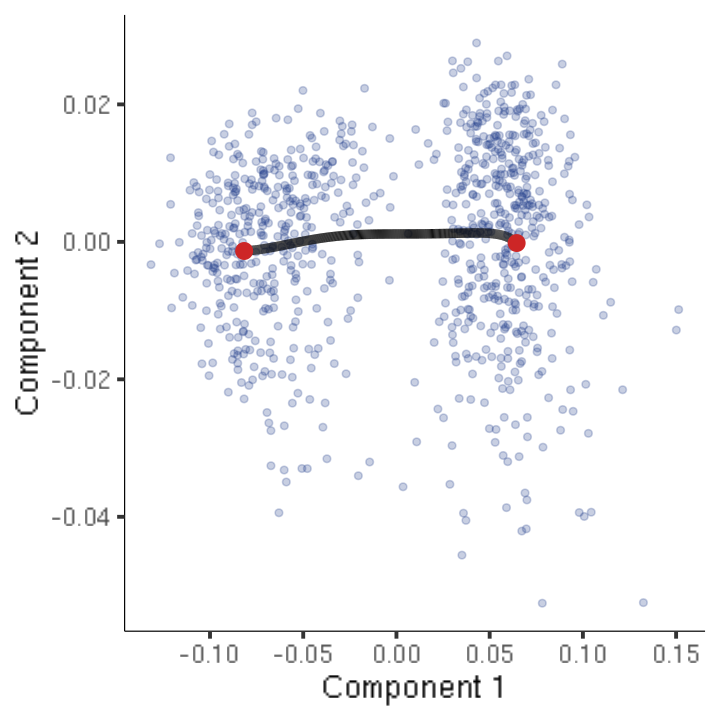

In [13]:
options(repr.plot.width=6, repr.plot.height=6)
plot.tree(ddr.tree.eigen.time.point)
ggsave("04_Expression/results/ddrtree_eigengene_time_point_expression.svg", width=6, height=6)

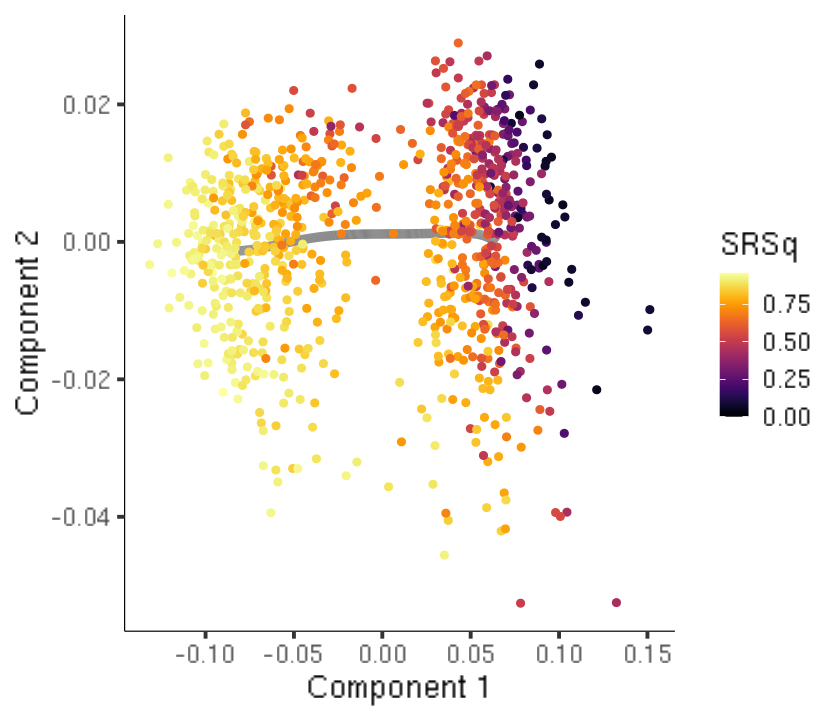

In [14]:
options(repr.plot.width=7, repr.plot.height=6)
plot.tree(ddr.tree.eigen.time.point, srs.info$SRSq, "SRSq")
ggsave("04_Expression/results/ddrtree_eigengene_time_point_expression_srsq.svg", width=7, height=6)

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


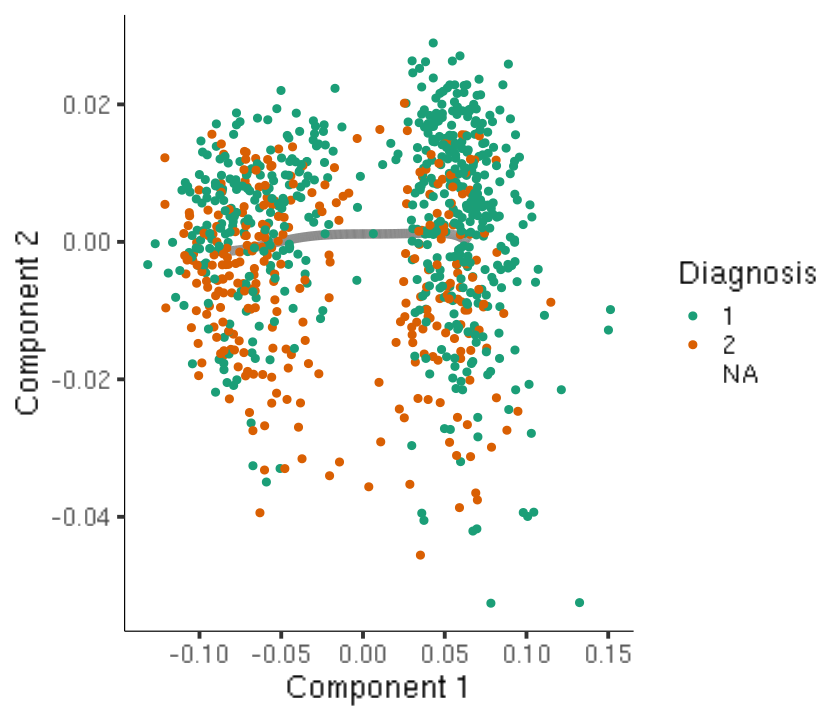

In [15]:
options(repr.plot.width=7, repr.plot.height=6)
plot.tree(ddr.tree.eigen.time.point, factor(sample.info$diagnosis), "Diagnosis")
ggsave("04_Expression/results/ddrtree_eigengene_time_point_expression_diagnosis.svg", width=7, height=6)

## Direction of Patient Movement

In some cases, patients provided multiple samples. Can we use these samples to figure out how patients are moving on the tree embedding?

In [16]:
S = summary(ddr.tree.eigen.time.point$stree) %>%
    dplyr::filter(i < j) %>%
    dplyr::arrange(i, j) %>%
    as.matrix()

head(S)

i,j,x
1,235,7.286468e-08
1,809,7.115579e-08
2,477,1.225398e-10
2,559,1.261607e-10
3,15,2.635867e-07
3,753,2.656401e-07


In [18]:
samples.with.pairs <- sample.info %>% 
    dplyr::mutate(Time.Point=sapply(strsplit(supplier_name, "_"), function(x) paste0("D", x[2]))) %>% 
    dplyr::select(GAinSID, Time.Point) %>%
    dplyr::mutate(Is.D1=Time.Point=="D1", Is.D3=Time.Point=="D3", Is.D5=Time.Point=="D5") %>%
    dplyr::group_by(GAinSID) %>%
    dplyr::summarize(D1.D3.Pair=any(Is.D1) && any(Is.D3), D3.D5.Pair=any(Is.D3) && any(Is.D5))
    
samples.with.d1.d3.pairs <- samples.with.pairs %>%
    dplyr::filter(D1.D3.Pair)

samples.with.d3.d5.pairs <- samples.with.pairs %>%
    dplyr::filter(D3.D5.Pair)
                                    
samples = dplyr::bind_rows(
    samples.with.d1.d3.pairs %>%
        dplyr::rowwise() %>%
        dplyr::mutate(i=which(rownames(eigengenes) == paste0(GAinSID, "_1"))) %>%
        dplyr::mutate(j=which(rownames(eigengenes) == paste0(GAinSID, "_3"))) %>%
        dplyr::select(i, j),
    samples.with.d3.d5.pairs %>%
        dplyr::rowwise() %>%
        dplyr::mutate(i=which(rownames(eigengenes) == paste0(GAinSID, "_3"))) %>%
        dplyr::mutate(j=which(rownames(eigengenes) == paste0(GAinSID, "_5"))) %>%
        dplyr::select(i, j)
) %>% as.matrix()

head(samples)

i,j
844,845
31,32
388,389
465,466
841,842
534,535


In [19]:
Y = ddr.tree.eigen.time.point$Y

head(Y)

,Centroid1,Centroid2,Centroid3,Centroid4,Centroid5,Centroid6,Centroid7,Centroid8,Centroid9,Centroid10,⋯,Centroid855,Centroid856,Centroid857,Centroid858,Centroid859,Centroid860,Centroid861,Centroid862,Centroid863,Centroid864
Comp1,0.041756784,6.407820e-02,-0.013474414,-0.0470000728,-0.0482651629,-0.0288850661,-0.0433407685,0.0595096923,-0.07935906,-0.071694853,⋯,-0.0351685560,0.01610607,0.0644693418,0.055872641,0.015597361,-0.0594061609,-0.016051033,0.047138179,0.045876665,-0.033140804
Comp2,0.001296594,-7.345176e-05,0.001113713,0.0002419003,0.0001792013,0.0009025912,0.0004129043,0.0007013549,-0.00128529,-0.001034045,⋯,0.0007282795,0.00117059,-0.0001688521,0.001012331,0.001169168,-0.0004191874,0.001095373,0.001277254,0.001287353,0.000791007


In [20]:
Z = ddr.tree.eigen.time.point$Z

head(Z)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
Comp1,0.05241449,0.069290767,-0.001601695,-0.045080273,-0.045559106,-0.03857842,-0.054103869,0.060284362,-0.07920782,-0.070879442,⋯,-0.042634080,0.03484555,0.09018776,0.054941595,0.03337985,-0.067239905,0.02534938,0.06436559,0.05866239,-0.04535016
Comp2,0.01525190,0.009167944,0.009531768,-0.001006131,-0.003282731,0.01037934,0.005983052,-0.008719153,-0.01342990,0.009941057,⋯,0.008432441,0.01014304,0.01790190,0.007994015,0.01210848,-0.007257465,0.02017618,0.01337888,0.01404801,0.01510232


In [21]:
Rcpp::sourceCpp("04_Expression/scripts/utils/stree_bfs.cpp")

In [22]:
vecs = stree_bfs(S, samples, Y)
vecs = t(vecs)
colnames(vecs) = c("D.Comp1", "D.Comp2", "Distance")

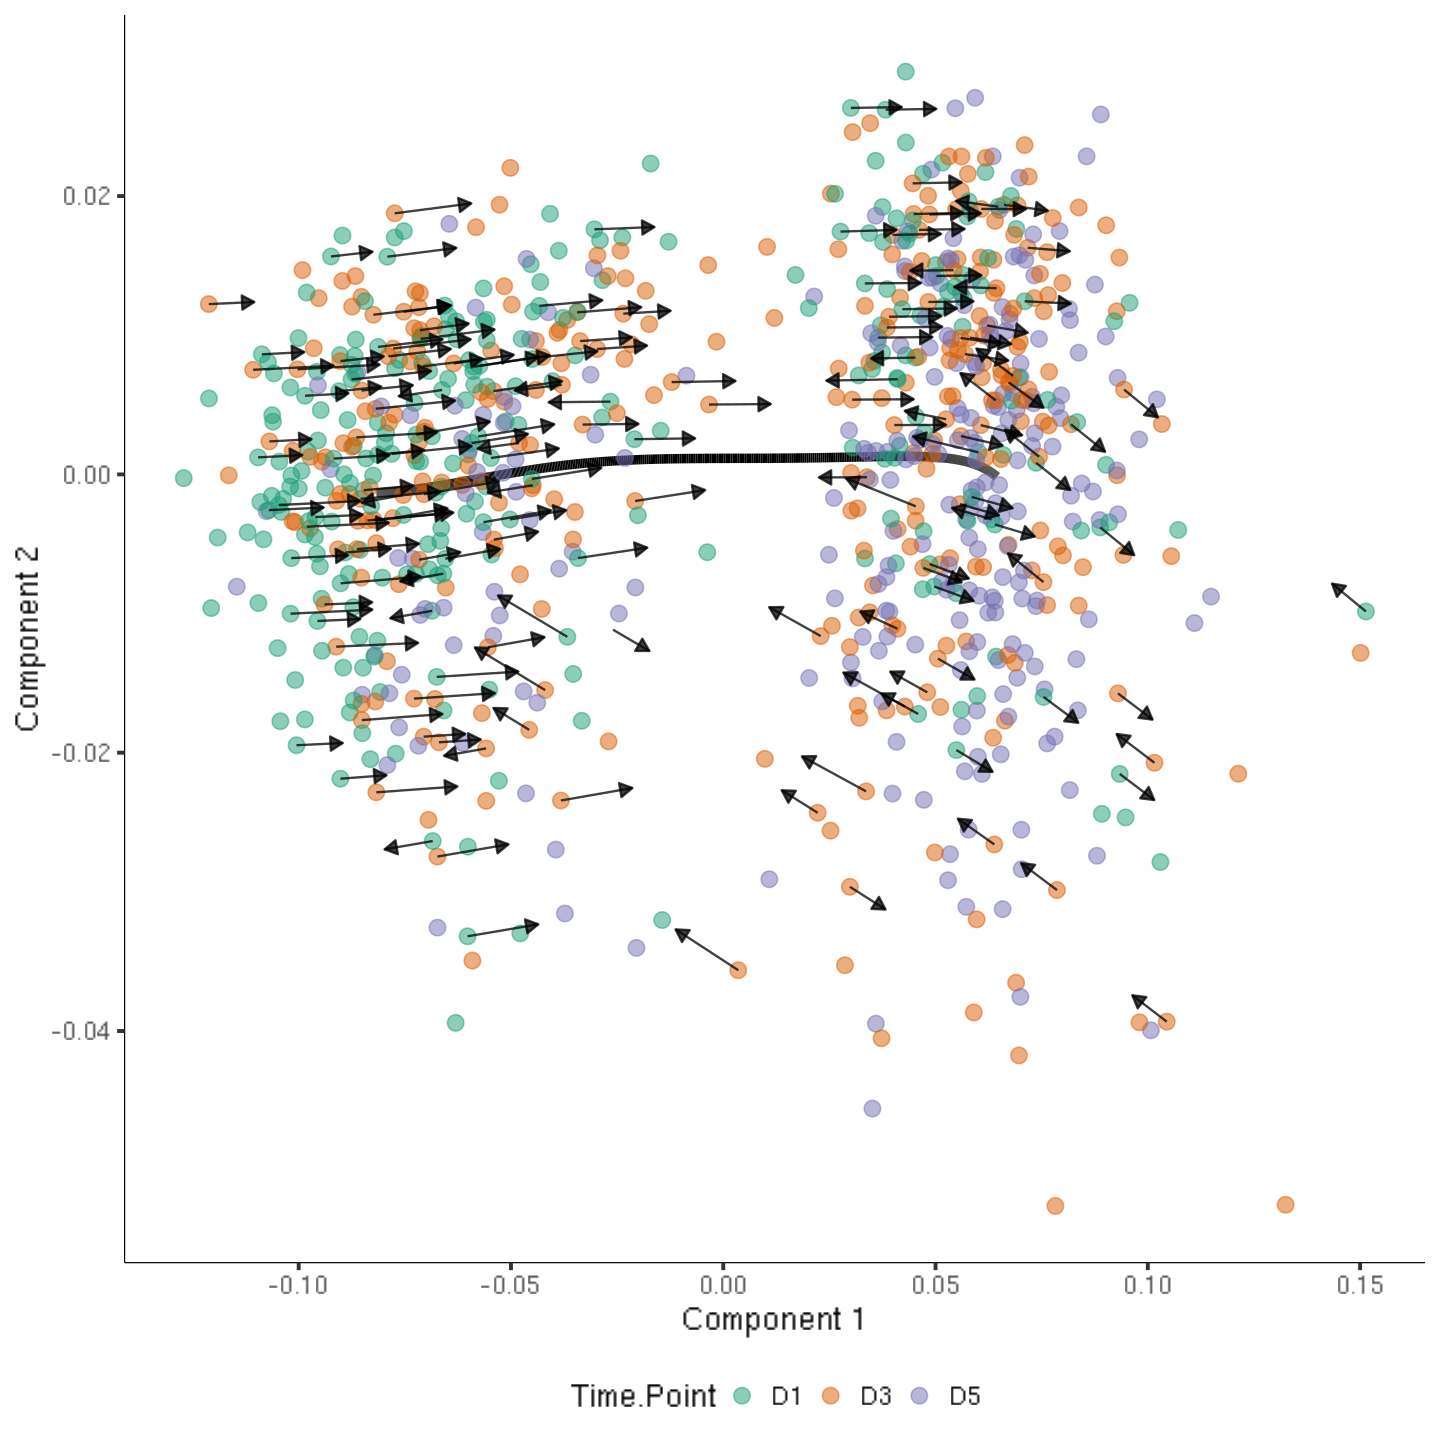

In [23]:
vec.data = samples %>%
    as.data.frame() %>%
    dplyr::mutate(Y.Comp1 = Z[1,i], Y.Comp2 = Z[2,i]) %>%
    dplyr::mutate(Y.Comp1.End = Y.Comp1 + (vecs[,1] / 100 + vecs[,1] / 15 * vecs[,3]), Y.Comp2.End = Y.Comp2 + (vecs[,2] / 100 + vecs[,2] / 15 * vecs[,3]))

Z.sample.info = t(ddr.tree.eigen.time.point$Z) %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Sample=colnames(gene.exp))

plot.data = sample.info %>%
    dplyr::mutate(Time.Point=sapply(strsplit(supplier_name, "_"), function(x) paste0("D", x[2]))) %>%
    merge(., Z.sample.info, by.x="supplier_name", by.y="Sample") %>%
    dplyr::select(Comp1, Comp2, Sample=GAinSID, Time.Point)

Y = t(ddr.tree.eigen.time.point$Y) %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2)
tree = as.data.frame(summary(ddr.tree.eigen.time.point$stree)) %>%
    dplyr::filter(i < j) %>%
    dplyr::mutate(StartComp1=Y$Comp1[i], StartComp2=Y$Comp2[i], EndComp1=Y$Comp1[j], EndComp2=Y$Comp2[j])

options(repr.plot.width=12, repr.plot.height=12)
ggplot() +
    geom_segment(data=tree, aes(x=StartComp1, y=StartComp2, xend=EndComp1, yend=EndComp2), size=I(2)) +
    geom_point(data=plot.data, aes(x=Comp1, y=Comp2, color=Time.Point), size=I(4), alpha=0.5) +
    geom_segment(data=vec.data, aes(x=Y.Comp1, y=Y.Comp2, xend=Y.Comp1.End, yend=Y.Comp2.End), arrow=arrow(length=unit(0.30,"cm"), type="closed"), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme
ggsave("04_Expression/results/ddrtree_eigengene_trajectory.svg", width=12, height=12)

## Pseudotime Associations

Since pseudotime was generated using eigengenes specifically associated with time point, it seems circular to test association of pseudotime with eigengenes.

It will be interesting to make sure that pseudotime is earlier in D1 time points and later in D5 time points, although it is a spectrum.

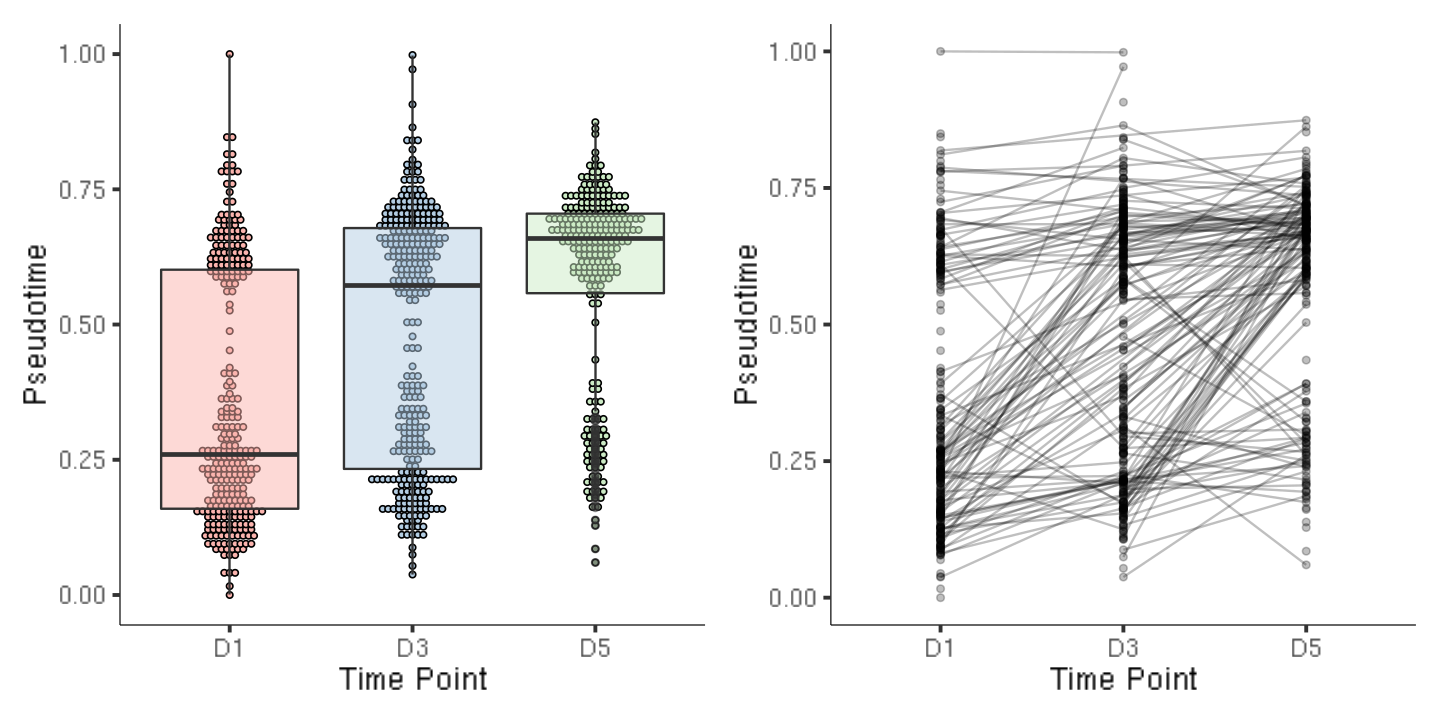

In [24]:
options(repr.plot.width=12, repr.plot.height=6)

p <- merge(sample.info, pseudotime, by.x="supplier_name", by.y=0) %>%
    dplyr::mutate(Time.Point=paste0("D", sapply(strsplit(supplier_name, "_"), function(x) x[2]))) %>%
    ggplot(aes(x=Time.Point, y=Pseudotime, fill=Time.Point)) +
    geom_dotplot(binaxis="y", binwidth=0.01, stackdir="center") +
    geom_boxplot(alpha=0.5) +
    guides(fill="none", color="none") +
    scale_fill_brewer(palette="Pastel1") +
    xlab("Time Point") +
    ggplot_theme

q <- merge(sample.info, pseudotime, by.x="supplier_name", by.y=0) %>%
    dplyr::mutate(Time.Point=paste0("D", sapply(strsplit(supplier_name, "_"), function(x) x[2]))) %>%
    ggplot(aes(x=Time.Point, y=Pseudotime)) +
    geom_point(alpha=0.25) +
    geom_line(aes(group=GAinSID), alpha=0.25) +
    xlab("Time Point") +
    ggplot_theme
                                                
p + q

ggsave("04_Expression/results/pseudotime_timepoints.svg", width=12, height=6)

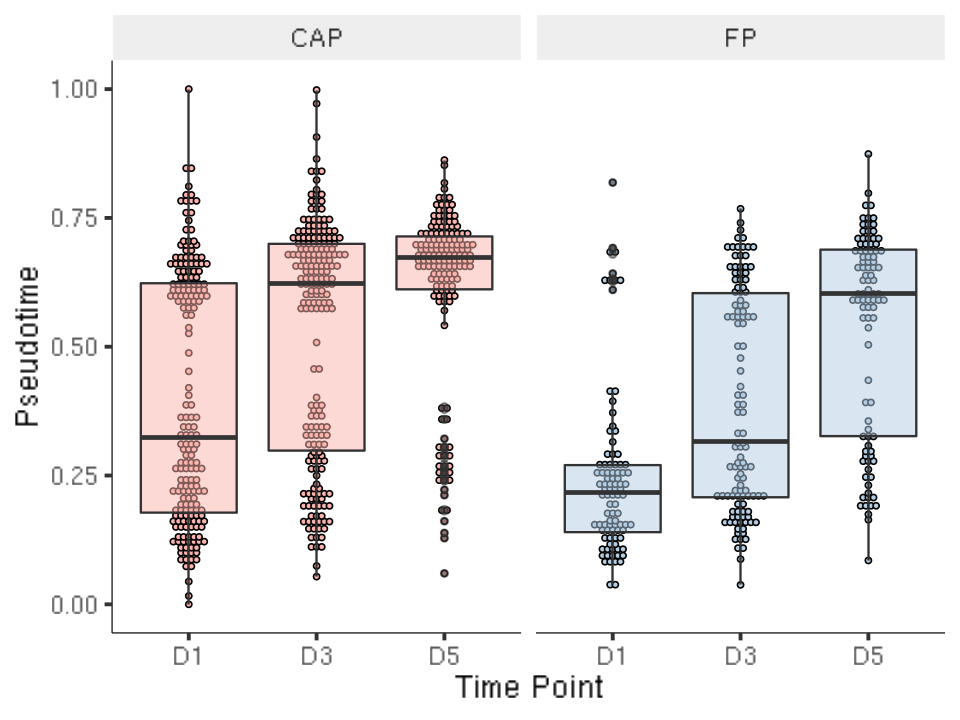

In [25]:
options(repr.plot.width=8, repr.plot.height=6)

merge(sample.info, pseudotime, by.x="supplier_name", by.y=0) %>%
    dplyr::mutate(Diagnosis=recode_factor(factor(diagnosis), `1`="CAP", `2`="FP")) %>%
    dplyr::filter(!is.na(Diagnosis)) %>%
    dplyr::mutate(Time.Point=paste0("D", sapply(strsplit(supplier_name, "_"), function(x) { x[2] }))) %>%
    ggplot(aes(x=Time.Point, y=Pseudotime, fill=Diagnosis)) +
    geom_dotplot(binaxis="y", binwidth=0.01, stackdir="center") +
    geom_boxplot(alpha=0.5) +
    xlab("Time Point") +
    guides(fill="none") +
    scale_fill_brewer(palette="Pastel1") +
    facet_grid(.~Diagnosis) +
    ggplot_theme

ggsave("04_Expression/results/pseudotime_timepoints_by_diagnosis.svg", width=8, height=6)

## Pseudotime and Outcome

Do patients who spend longer in SRS1 (earlier stage of sepsis) have poorer outcomes compared with patients that move quickly towards SRS2?

In [26]:
velocity <- merge(sample.info, pseudotime, by.x="supplier_name", by.y=0) %>%
    dplyr::mutate(Time.Point=paste0("D", sapply(strsplit(supplier_name, "_"), function(x) { x[2] }))) %>%
    dplyr::select(GAinS.ID=GAinSID, Pseudotime, Time.Point, Status) %>%
    tidyr::spread(Time.Point, Pseudotime) %>%
    dplyr::rowwise() %>%
    dplyr::mutate(Days = sum(!is.na(D1), !is.na(D3), !is.na(D5))) %>%
    dplyr::filter(Days >= 2) %>%
    dplyr::mutate(First.Pseudotime = ifelse(is.na(D1), D3, D1)) %>%
    dplyr::mutate(First.Pseudotime.Time.Point = ifelse(is.na(D1), 3, 1)) %>%
    dplyr::mutate(Last.Pseudotime = ifelse(is.na(D5), D3, D5)) %>%
    dplyr::mutate(Last.Pseudotime.Time.Point = ifelse(is.na(D5), 3, 5)) %>%
    dplyr::mutate(Velocity = (Last.Pseudotime - First.Pseudotime) / (Last.Pseudotime.Time.Point - First.Pseudotime.Time.Point))

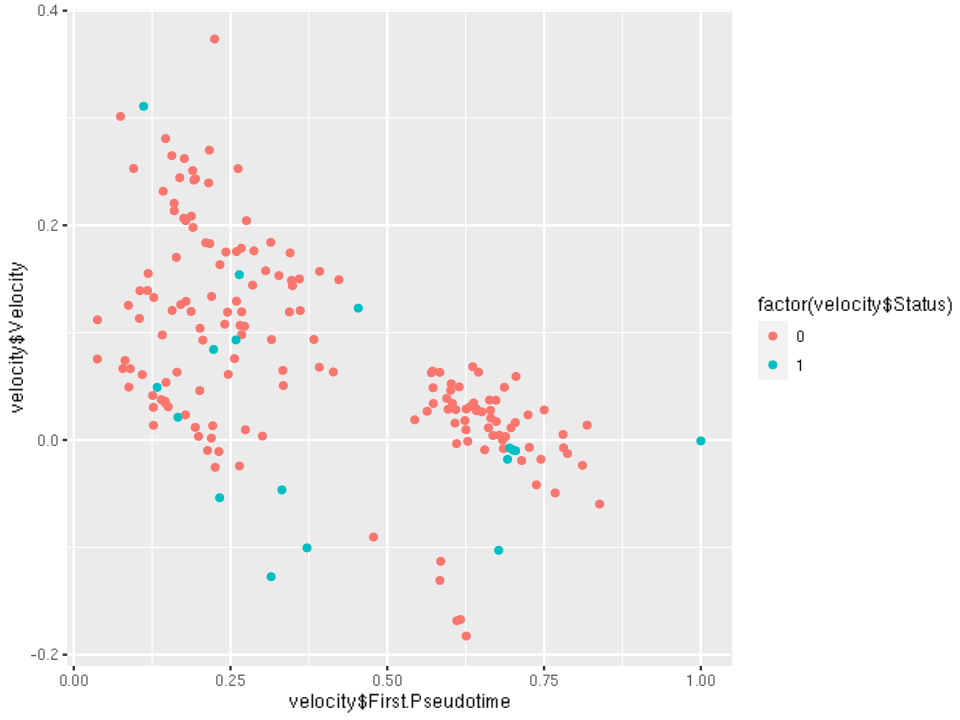

In [27]:
qplot(velocity$First.Pseudotime, velocity$Velocity, color=factor(velocity$Status))

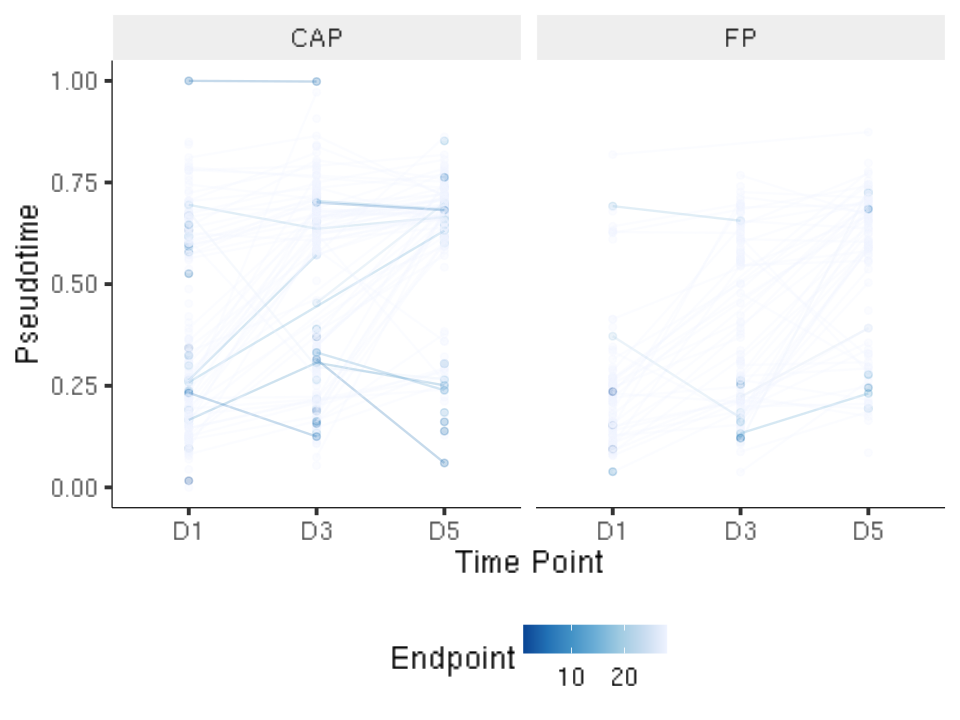

In [28]:
merge(sample.info, pseudotime, by.x="supplier_name", by.y=0) %>%
    dplyr::mutate(Diagnosis=recode_factor(factor(diagnosis), `1`="CAP", `2`="FP")) %>%
    dplyr::filter(!is.na(Diagnosis)) %>%
    dplyr::mutate(Time.Point=paste0("D", sapply(strsplit(supplier_name, "_"), function(x) { x[2]} ))) %>%
    ggplot(aes(x=Time.Point, y=Pseudotime)) +
    geom_point(aes(color=Endpoint), alpha=0.25) +
    geom_line(aes(group=GAinSID, color=Endpoint), alpha=0.25) +
    xlab("Time Point") +
    scale_color_distiller(palette="Blues") +
    facet_grid(.~Diagnosis) +
    ggplot_theme

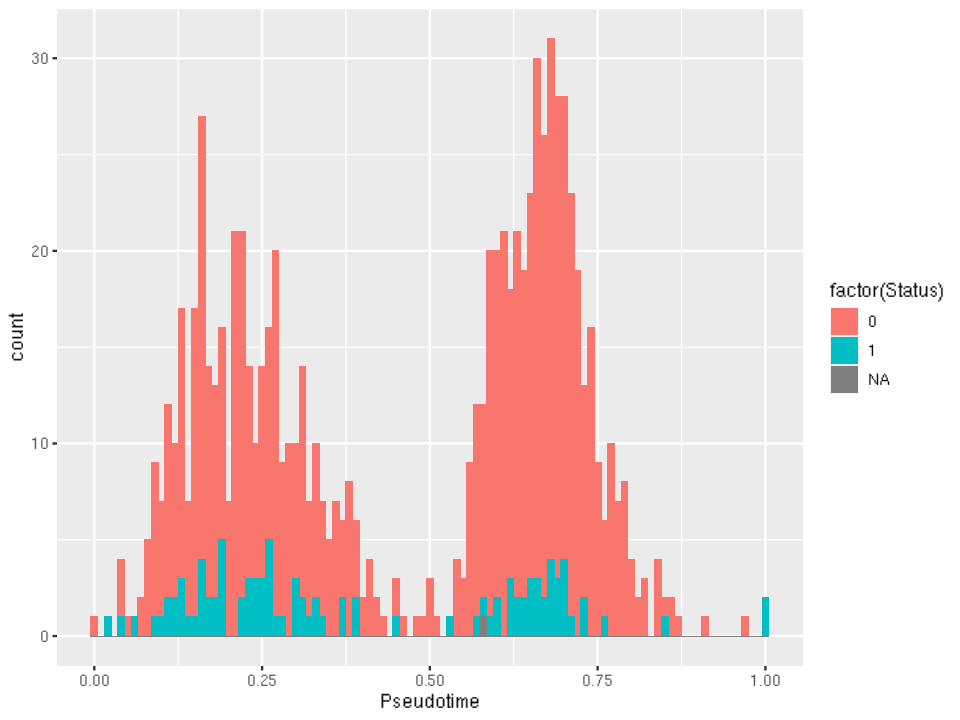

In [29]:
merge(sample.info, pseudotime, by.x="supplier_name", by.y=0) %>%
    ggplot() +
    geom_histogram(aes(Pseudotime, fill=factor(Status)), binwidth=0.01)